# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [1]:
from __future__ import print_function, division


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier



%matplotlib inline



## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [2]:
# Loading dataset
images_TA = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(images_TA)

images_VA = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(images_VA)

# Data points
print('Data points for train_A: {}''\n''Data points for valid_A: {}'.format(train_A.shape[0], valid_A.shape[0]))


Data points for train_A: 2093
Data points for valid_A: 1113


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [3]:
train_A.head(10).describe()
#train_A.head(10)

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.0,10.0,10.000000
mean,0.001323,0.001378,0.003231,0.000981,0.001586,0.002861,0.000965,0.003613,0.001945,0.002949,...,0.0,0.100000,0.100000,0.100000,0.0,0.400000,0.0,0.0,0.0,0.100000
std,0.000967,0.001930,0.002671,0.001001,0.001267,0.002186,0.000809,0.002370,0.001667,0.002110,...,0.0,0.316228,0.316228,0.316228,0.0,0.516398,0.0,0.0,0.0,0.316228
min,0.000000,0.000000,0.000000,0.000279,0.000372,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
25%,0.000600,0.000340,0.000619,0.000348,0.000719,0.001507,0.000340,0.002260,0.000093,0.001762,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
50%,0.001189,0.000474,0.003603,0.000605,0.001359,0.002135,0.000882,0.003219,0.002505,0.002645,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
75%,0.002065,0.002014,0.004682,0.001036,0.001646,0.004743,0.001386,0.004076,0.003397,0.004755,...,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000
max,0.002976,0.006324,0.007422,0.003516,0.003906,0.006114,0.002378,0.008185,0.003646,0.006138,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [4]:
#train_A.values.tolist()[:500]
names = train_A.columns.values[1 : 501] 
attributes = names.tolist()
attributes

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10',
 'dim11',
 'dim12',
 'dim13',
 'dim14',
 'dim15',
 'dim16',
 'dim17',
 'dim18',
 'dim19',
 'dim20',
 'dim21',
 'dim22',
 'dim23',
 'dim24',
 'dim25',
 'dim26',
 'dim27',
 'dim28',
 'dim29',
 'dim30',
 'dim31',
 'dim32',
 'dim33',
 'dim34',
 'dim35',
 'dim36',
 'dim37',
 'dim38',
 'dim39',
 'dim40',
 'dim41',
 'dim42',
 'dim43',
 'dim44',
 'dim45',
 'dim46',
 'dim47',
 'dim48',
 'dim49',
 'dim50',
 'dim51',
 'dim52',
 'dim53',
 'dim54',
 'dim55',
 'dim56',
 'dim57',
 'dim58',
 'dim59',
 'dim60',
 'dim61',
 'dim62',
 'dim63',
 'dim64',
 'dim65',
 'dim66',
 'dim67',
 'dim68',
 'dim69',
 'dim70',
 'dim71',
 'dim72',
 'dim73',
 'dim74',
 'dim75',
 'dim76',
 'dim77',
 'dim78',
 'dim79',
 'dim80',
 'dim81',
 'dim82',
 'dim83',
 'dim84',
 'dim85',
 'dim86',
 'dim87',
 'dim88',
 'dim89',
 'dim90',
 'dim91',
 'dim92',
 'dim93',
 'dim94',
 'dim95',
 'dim96',
 'dim97',
 'dim98',
 'dim99',
 'dim100',
 'dim101

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [5]:
X_tr = np.array(train_A[attributes])
X_val = np.array(valid_A[attributes])

y_tr = np.array(train_A['is_person'].values)
y_val = np.array(valid_A['is_person'].values) 

# Dimensionalities
print('Shapes for''\n''X_tr: {}''\n''X_val: {}''\n''y_tr: {}''\n''y_val: {}'.format(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape))

Shapes for
X_tr: (2093, 500)
X_val: (1113, 500)
y_tr: (2093,)
y_val: (1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

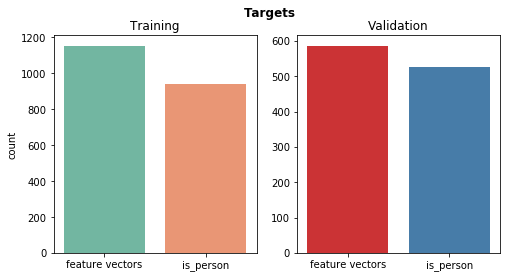

In [6]:
# Plotting training and validation targets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(y_tr, ax=ax1, palette="Set2")
ax1.set_title('Training', size=12)
ax1.set_xlabel(' ')
sns.countplot(y_val, ax=ax2, palette="Set1")
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Validation', size=12)
fig.suptitle('Targets', size=12, fontweight = 'bold')

# Using xticklabels
the_labels = ['feature vectors', 'is_person']

ax1.set_xticklabels(the_labels)
ax2.set_xticklabels(the_labels)

plt.show()

### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

I would use sklearn's DummyClassifier which looks at which attribute occurs most frequently thus making it the simplest possible prediction classifier. As we can clearly see in Q1.5, the is_person attribute is the lower of the two which means the DummyClassifier will always classify our attributes as a picture that doesn't have people in it - this leaves us with much room for improvement. 

In [7]:
baseline_c = DummyClassifier(strategy="most_frequent")
baseline = baseline_c.fit(X_tr, y_tr)

print('Classification accuracy for baseline DummyClassifier: {}'.format(baseline.score(X_val, y_val)))

Classification accuracy for baseline DummyClassifier: 0.526504941599


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

In [8]:
lr = LogisticRegression(solver='lbfgs')
l_r = lr.fit(X_tr, y_tr)

print('Classification accuracy for LogisticRegression, training sets: {}'.format(l_r.score(X_tr, y_tr)))
print()
print('Classification accuracy for LogisticRegression, validation sets: {}'.format(l_r.score(X_val, y_val)))

Classification accuracy for LogisticRegression, training sets: 0.55088389871

Classification accuracy for LogisticRegression, validation sets: 0.526504941599


The results are similar to the accuracy score for the baseline model. LogistricRegression is a probabilistic model and gives linear class boundaries. Because our data is such that the training and validation sets both have higher counts for feature vectors (as seen in Q1.5), this classifier almost behaves the same way as the DummyClassifier that just takes the attributes that occur most frequently. 



### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations for each column in your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [9]:
print('Mean for first 5 features in the training set:\n\n{}'.format(X_tr.mean(axis=0)[0:5]))

Mean for first 5 features in the training set:

[ 0.00175058  0.00075592  0.00431695  0.00185278  0.00227248]


In [10]:
print('Std. Dev for first 5 features in the training set:\n\n{}'.format(X_tr.std(axis=0)[0:5]))

Std. Dev for first 5 features in the training set:

[ 0.00119281  0.00140604  0.00369255  0.00134017  0.00159773]


### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [11]:
# Instantiate StandardScaler and fit using training features
standard_scaler = StandardScaler().fit(X_tr)


# Feature standardisation for training and validation features
X_tr = standard_scaler.transform(X_tr)
X_val = standard_scaler.transform(X_val)


In [12]:
print('Mean for first 5 features in the transformed training set:\n\n{}'.format(X_tr.mean(axis=0)[0:5]))

Mean for first 5 features in the transformed training set:

[ -3.39485301e-17  -2.20665446e-17   2.44429417e-16   1.42583827e-16
  -5.77125012e-17]


In [13]:
print('Std. Dev for first 5 features in the transformed validation set:\n\n{}'.format(X_val.std(axis=0)[0:5]))

Std. Dev for first 5 features in the transformed validation set:

[ 1.01310886  0.96981949  1.0492285   1.05684479  0.97471336]


The mean is closer to 0 and the standard deviation is closer to 1. This is the expected outcome after transforming the data using a StandardScaler. We fit the StandardScaler and standardise the data using the training set because we want to create a predictive model that is generalized. The standardisation parameters are calculated according to the training data so that the validation process can be applied after and not have any contamination via future information.

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [14]:
lr_transformed = LogisticRegression(solver='lbfgs')
l_r_transformed = lr_transformed.fit(X_tr, y_tr)

print('Classification accuracy for LogisticRegression, transformed training sets: {}'.format(l_r_transformed.score(X_tr, y_tr)))
print()
print('Classification accuracy for LogisticRegression, transformed validation sets: {}'.format(l_r_transformed.score(X_val, y_val)))

Classification accuracy for LogisticRegression, transformed training sets: 0.810797897754

Classification accuracy for LogisticRegression, transformed validation sets: 0.643306379155


The new LogisticRegression classifier does much better on the transformed training data than the DummyClassifier and significantly better on the transformed validation sets. This is because the preprocessing allowed the individual features to look more like standard normal distributed data.

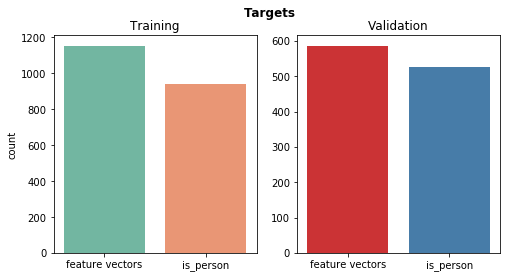

In [15]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(y_tr, ax=ax1, palette="Set2")
ax1.set_title('Training', size=12)
ax1.set_xlabel(' ')
sns.countplot(y_val, ax=ax2, palette="Set1")
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Validation', size=12)
fig.suptitle('Targets', size=12, fontweight = 'bold')

# Using xticklabels
the_labels = ['feature vectors', 'is_person']

ax1.set_xticklabels(the_labels)
ax2.set_xticklabels(the_labels)

plt.show()

### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [16]:
kf = KFold(n_splits=3, random_state=0, shuffle=True)
kf.get_n_splits(X_tr)

for training_samples, validation_samples in kf.split(X_tr):
    print(len(validation_samples))

698
698
697


### ========== Question 1.12 --- [2 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [17]:
C = np.logspace(-5, 5, num=20, base = 10)

# Creating a 2D array                
matrix = [[0 for x in range (len(C))] for x in range(kf.n_splits)] 

# Numbering the kf folds
folds = 0
                
for training_samples, validation_samples in kf.split(X_tr):
    for C_index, C_values in enumerate(C):
        lr_kfold = LogisticRegression(solver='lbfgs', C=C_values)
        l_r_kfold = lr_kfold.fit(X_tr[training_samples], y_tr[training_samples])
      
        matrix[folds][C_index] = accuracy_score(y_tr[validation_samples], l_r_kfold.predict(X_tr[validation_samples]))
    folds= folds+1
    
print('Classification accuracy for each cross-validation fold and parameter setting pair: \n\n{}'.format(matrix))
       

Classification accuracy for each cross-validation fold and parameter setting pair: 

[[0.57306590257879653, 0.62893982808022919, 0.66762177650429799, 0.67191977077363896, 0.68767908309455583, 0.69627507163323787, 0.67478510028653294, 0.67048710601719197, 0.65329512893982811, 0.65902578796561606, 0.65902578796561606, 0.65329512893982811, 0.64899713467048714, 0.64613180515759316, 0.64613180515759316, 0.64899713467048714, 0.64613180515759316, 0.64613180515759316, 0.64899713467048714, 0.64899713467048714], [0.54584527220630374, 0.63180515759312317, 0.69484240687679089, 0.71919770773638969, 0.72922636103151861, 0.73495702005730656, 0.70200573065902583, 0.67478510028653294, 0.6547277936962751, 0.63610315186246413, 0.63180515759312317, 0.63323782234957016, 0.62607449856733521, 0.6275071633237822, 0.6275071633237822, 0.62607449856733521, 0.62607449856733521, 0.62607449856733521, 0.6275071633237822, 0.62607449856733521], [0.54806312769010046, 0.63558106169296991, 0.642754662840746, 0.6556671449

### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

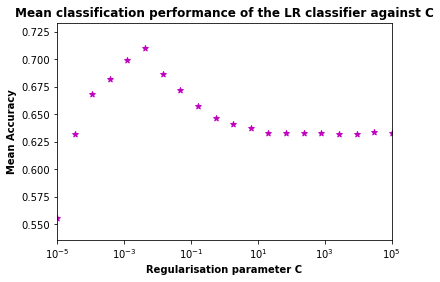

In [18]:
# Finding the mean
m_perf = np.mean(matrix, axis=0)

# Plotting
plt.scatter(C, m_perf, color="m", marker="*")

plt.xscale('log') 

plt.xlim([.00001, 100000])

# Title and labels
plt.title('Mean classification performance of the LR classifier against C', fontweight='bold')
plt.ylabel('Mean Accuracy', fontweight='bold')
plt.xlabel('Regularisation parameter C', fontweight='bold')
        

### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [19]:
# The index at which it yields the highest average classification accuracy
print(np.argmax(m_perf))

print('Mean accuracy score when using the optimal value: {}'.format(m_perf[5]))
print('Optimal value for the regularisation parameter C: {}'.format(C[5]))

lr_optimal = LogisticRegression(solver='lbfgs', C=0.00428133239872)
l_r_optimal = lr_optimal.fit(X_tr, y_tr)

print('Classification accuracy for LogisticRegression, using the optimal C value: {}'.format(l_r_optimal.score(X_val, y_val)))

5
Mean accuracy score when using the optimal value: 0.710458521238
Optimal value for the regularisation parameter C: 0.00428133239872
Classification accuracy for LogisticRegression, using the optimal C value: 0.696316262354


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [20]:
lr_CV = LogisticRegressionCV(Cs=C, cv=3, solver='lbfgs')
l_r_CV = lr_CV.fit(X_tr, y_tr)

print('Optimal value for the regularisation parameter C: {}'.format(l_r_CV.C_))    
print('Classification accuracy with LRCV: {}'.format(l_r_CV.score(X_val, y_val)))

Optimal value for the regularisation parameter C: [ 0.00428133]
Classification accuracy with LRCV: 0.696316262354


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to the labs if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [21]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
r_f = rf.fit(X_tr, y_tr)


print('Classification accuracy with RandomForest for training sets: {}'.format(r_f.score(X_tr, y_tr)))
print('Classification accuracy with RandomForest for validation sets: {}'.format(r_f.score(X_val, y_val)))


Classification accuracy with RandomForest for training sets: 1.0
Classification accuracy with RandomForest for validation sets: 0.692722371968


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

The descrepancy between accuracies is not surprising. The more trees are used in a RandomForestClassifier, the better the accuracy of the validation sets. With the size of our dataset, using 500 trees shows us a good accuracy (0.692722371968) score but when using say 5000 trees, the accuracy score increases (0.700808625337), thus lowering the discrepancy. However, using more trees would be computationally expensive. As for the perfect score on training sets, this can be explained by overfitting and no pruning. 

### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [22]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
r_f = rf.fit(X_tr, y_tr)

attributes = np.array(attributes)
print(attributes[(np.argsort(-r_f.feature_importances_))][:50])



['dim21' 'dim51' 'dim360' 'dim4' 'dim479' 'dim76' 'dim283' 'dim461'
 'dim343' 'dim398' 'dim348' 'dim74' 'dim485' 'dim356' 'dim330' 'dim217'
 'dim263' 'dim222' 'dim134' 'dim500' 'dim274' 'dim254' 'dim206' 'dim423'
 'dim347' 'dim17' 'dim326' 'dim90' 'dim92' 'dim329' 'dim214' 'dim322'
 'dim289' 'dim54' 'dim440' 'dim427' 'dim73' 'dim35' 'dim77' 'dim312'
 'dim315' 'dim96' 'dim288' 'dim483' 'dim299' 'dim48' 'dim442' 'dim201'
 'dim344' 'dim294']


### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [23]:
# Linear SVM
svc_linear = LinearSVC()
svc_linear.fit(X_tr, y_tr)

print('Classification accuracy with Linear SVM')
print('Training sets: {}'.format(svc_linear.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_linear.score(X_val, y_val)))
print()

# Radial Basis SVM
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr, y_tr)

print('Classification accuracy with Radial Basis SVM')
print('Training sets: {}'.format(svc_rbf.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_rbf.score(X_val, y_val)))
print()

# Polynomial SVM
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr, y_tr)

print('Classification accuracy with Polynomial SVM')
print('Training sets: {}'.format(svc_poly.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_poly.score(X_val, y_val)))

Classification accuracy with Linear SVM
Training sets: 0.79646440516
Validation sets: 0.627133872417

Classification accuracy with Radial Basis SVM
Training sets: 0.910654562828
Validation sets: 0.729559748428

Classification accuracy with Polynomial SVM
Training sets: 0.990922121357
Validation sets: 0.701707097934


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [24]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

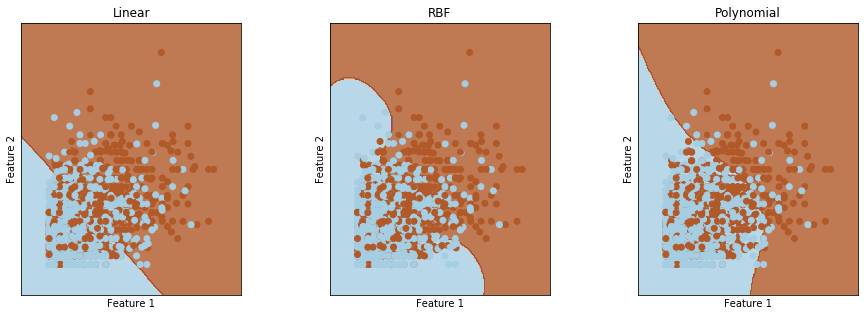

In [25]:
# Creating a list
clfs = []

# Defining X and y 
X = X_tr[:, [20, 75]]
y = y_tr


# Linear SVM
svc_linear_new = LinearSVC()
svcl = svc_linear_new.fit(X, y)

# Radial Basis Function SVM
svc_rbf_new = SVC(kernel='rbf')
svcr = svc_rbf_new.fit(X, y)

# Polynomial SVM
svc_poly_new = SVC(kernel='poly')
svcp = svc_poly_new.fit(X, y)

# Filling the list
clfs.append(svcl)
clfs.append(svcr)
clfs.append(svcp)

show_svc_decision_boundaries(clfs, X, title=["Linear", "RBF", "Polynomial"])


Accuracy scores improve when using kernels and so we can see that RBF and Polynomial boundary shapes allow for better accuracy than the Linear SVM. Furthermore, a Linear SVM does not do as well with data from images because these are continuous data. RBF has the most relevant separating hyperplane because it can fit smooth solutions for image classifying.  

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [26]:
C2 = np.logspace(-2, 3, 10)

# Creating a 2D array                
matrix2 = [] 
        
# Looping through and getting the accuracy score for each iteration
for C2_index, C2_values in enumerate(C2):
    svc_rbf_CV = SVC(kernel='rbf', gamma='auto', C=C2_values)
    svc_AC = cross_val_score(svc_rbf_CV, X_tr, y_tr, cv = kf)
    matrix2.append(cross_val_score(svc_rbf_CV, X_tr, y_tr, cv = kf))

print(matrix2)

[array([ 0.56017192,  0.54584527,  0.54662841]), array([ 0.58309456,  0.54584527,  0.54806313]), array([ 0.67191977,  0.69770774,  0.68579627]), array([ 0.70200573,  0.73782235,  0.69727403]), array([ 0.71346705,  0.73925501,  0.69296987]), array([ 0.70916905,  0.71346705,  0.68292683]), array([ 0.70916905,  0.71346705,  0.68292683]), array([ 0.70916905,  0.71346705,  0.68292683]), array([ 0.70916905,  0.71346705,  0.68292683]), array([ 0.70916905,  0.71346705,  0.68292683])]


In [27]:
# Finding the mean
m_SVC = np.mean(matrix2, axis=1)

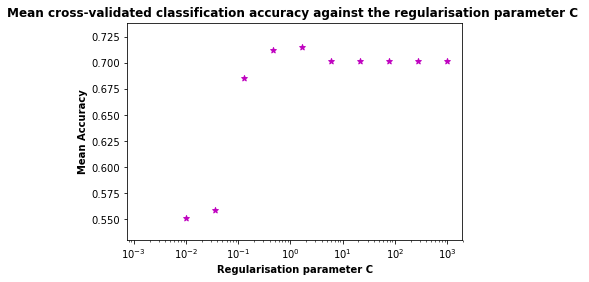

In [28]:
# Plotting
plt.scatter(C2, m_SVC, color="m", marker="*")

plt.xscale('log') 

# Title and labels
plt.title('Mean cross-validated classification accuracy against the regularisation parameter C ', fontweight='bold')
plt.ylabel('Mean Accuracy', fontweight='bold')
plt.xlabel('Regularisation parameter C', fontweight='bold')

In [29]:
# The index at which it yields the highest average classification accuracy
print(np.argmax(m_SVC))

print('Mean accuracy score when using the optimal value: {}'.format(m_SVC[4]))
print('Optimal value for the regularisation parameter C: {}'.format(C2[4]))

svc_rbf_X = SVC(kernel='rbf', gamma='auto', C=1.6681005372)
svc_X = svc_rbf_X.fit(X_tr, y_tr)

print('\nClassification accuracy for SVM, using the optimal C value')
print('Training sets: {}'.format(svc_X.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_X.score(X_val, y_val)))

4
Mean accuracy score when using the optimal value: 0.715230644637
Optimal value for the regularisation parameter C: 1.6681005372

Classification accuracy for SVM, using the optimal C value
Training sets: 0.974677496417
Validation sets: 0.727762803235


### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [30]:
C3 = np.logspace(-5, 0, 10)

# Creating a 2D array                
matrix3 = [] 
type(matrix3)
                
# Looping through and getting the accuracy score for each iteration
for C3_index, C3_values in enumerate(C3):
    svc_rbf_CV = SVC(kernel='rbf', gamma=C3_values, C=1.0)
    svc_AC = cross_val_score(svc_rbf_CV, X_tr, y_tr, cv = kf)
    matrix3.append(cross_val_score(svc_rbf_CV, X_tr, y_tr, cv = kf))

print(matrix3)

[array([ 0.56160458,  0.54584527,  0.54662841]), array([ 0.66189112,  0.65902579,  0.64418938]), array([ 0.67191977,  0.71060172,  0.65710187]), array([ 0.70487106,  0.74498567,  0.68149211]), array([ 0.71346705,  0.74212034,  0.69296987]), array([ 0.71060172,  0.7234957 ,  0.68292683]), array([ 0.56017192,  0.54584527,  0.54662841]), array([ 0.56017192,  0.54584527,  0.54662841]), array([ 0.56017192,  0.54584527,  0.54662841]), array([ 0.56017192,  0.54584527,  0.54662841])]


In [31]:
# Finding the mean
m_SVC_g = np.mean(matrix3, axis=1)

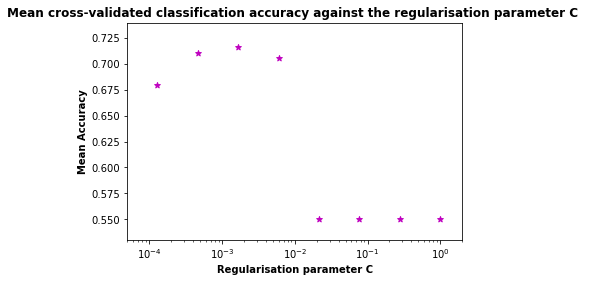

In [32]:
# Plotting
plt.scatter(C3, m_SVC_g, color="m", marker="*")

plt.xscale('log') 
plt.xlim([.00005, 2])

# Title and labels
plt.title('Mean cross-validated classification accuracy against the regularisation parameter C ', fontweight='bold')
plt.ylabel('Mean Accuracy', fontweight='bold')
plt.xlabel('Regularisation parameter C', fontweight='bold')

In [33]:
# The index at which it yields the highest average classification accuracy
print(np.argmax(m_SVC_g))

print('Mean accuracy score when using the optimal value: {}'.format(m_SVC_g[4]))
print('Optimal value for the regularisation parameter C: {}'.format(C3[4]))

svc_rbf_Z = SVC(kernel='rbf', gamma='auto', C=0.0016681005372)
svc_Z = svc_rbf_Z.fit(X_tr, y_tr)

print('\nClassification accuracy for SVM, using the optimal C value')
print('Training sets: {}'.format(svc_X.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_X.score(X_val, y_val)))

4
Mean accuracy score when using the optimal value: 0.716185754475
Optimal value for the regularisation parameter C: 0.0016681005372

Classification accuracy for SVM, using the optimal C value
Training sets: 0.974677496417
Validation sets: 0.727762803235


### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [34]:
C4 = np.logspace(-2, 1, 4)
g1 = np.logspace(-4, -1, 4)

# Creating a 4 by 4 grid               
matrix4 = [[0 for x in range (len(C4))] for x in range(len(g1))]

for g1_index, g1_values in enumerate(g1):
    for C4_index, C4_values in enumerate(C4):
        svc_rbf_cg = SVC(kernel='rbf', gamma=g1_values, C=C4_values)
        matrix4[g1_index][C4_index] = np.mean(cross_val_score(svc_rbf_cg, X_tr, y_tr, cv = kf))
    
    
print('mean cross-validated classification accuracy: \n\n{}'.format(matrix4))

mean cross-validated classification accuracy: 

[[0.55088186647920756, 0.55088186647920756, 0.68130985708980629, 0.70997754053050388], [0.55088186647920756, 0.68322692834209653, 0.71236257449377127, 0.69086986251625537], [0.55088186647920756, 0.55088186647920756, 0.64595571962798681, 0.66363004772808554], [0.55088186647920756, 0.55088186647920756, 0.55088186647920756, 0.55088186647920756]]


In [35]:
# Finding the mean
m_svc_rbf_cg = np.mean(matrix4, axis=1)
m_svc_rbf_cg

array([ 0.62326278,  0.65933531,  0.60283738,  0.55088187])

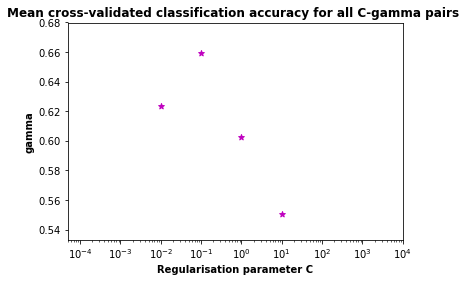

In [36]:
# Plotting
plt.scatter(C4, m_svc_rbf_cg, color="m", marker="*")

plt.xscale('log') 
plt.xlim([.00005, 10000])

# Title and labels
plt.title('Mean cross-validated classification accuracy for all C-gamma pairs ', fontweight='bold')
plt.ylabel('gamma', fontweight='bold')
plt.xlabel('Regularisation parameter C', fontweight='bold')

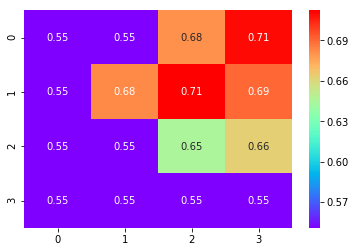

In [37]:
# Plotting heat map
cgamma_hot = sns.heatmap(matrix4, cmap=plt.cm.rainbow, annot=True)

In [38]:
# The index at which it yields the highest average classification accuracy
print(np.argmax(m_svc_rbf_cg))

print('Mean accuracy score when using the optimal value: {}'.format(m_svc_rbf_cg[1]))
print('Optimal value for the regularisation parameter C: {}'.format(C4[1]))
print('Optimal value for the regularisation parameter gamma: {}'.format(g1[1]))


svc_rbf_cg2 = SVC(kernel='rbf', gamma=0.001, C=0.1)
svc_cg2 = svc_rbf_cg2.fit(X_tr, y_tr)

print('\nClassification accuracy for SVM, using the optimal C and gamma value')
print('Training sets: {}'.format(svc_cg2.score(X_tr, y_tr)))
print('Validation sets: {}'.format(svc_cg2.score(X_val, y_val)))

1
Mean accuracy score when using the optimal value: 0.659335307958
Optimal value for the regularisation parameter C: 0.1
Optimal value for the regularisation parameter gamma: 0.001

Classification accuracy for SVM, using the optimal C and gamma value
Training sets: 0.718107978978
Validation sets: 0.685534591195


### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

The classification accuracy on the validation set is not higher than in the previous question. This is because in Q1.23, both C and gamma optimal values were used to fit the model unlike in Q1.22 (where only the optimal C value was used).

It is likely that the model may have been overfitted with the use of both parameters because C values lead to memorizing the training set while gamma values lead to a 'narrow Gaussians that are condensed around each point' (source:  https://stackoverflow.com/questions/23391151/are-high-values-for-c-or-gamma-problematic-when-using-an-rbf-kernel-svm). Because of this, when applied to the validation sets, we have a lower accuracy score since the model is now not generalized enough.

Another way to further improve the performance of the classifier is by using Leave One Out cross validation. However, it has a high variation since only one validation set is used. 


### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [39]:
d_p = np.arange(1,8)

# Creating a matrix               
matrix_A = []

#print(type(matrix_A))
                
# Looping through and getting the accuracy score for each iteration
for n in d_p:
    svc_poly_1 = SVC(kernel='poly', gamma='auto', degree=n)
    #svc_poly = cross_val_score(svc_poly_1, X_tr, y_tr, cv = kf)
    matrix_A.append(cross_val_score(svc_poly_1, X_tr, y_tr, cv = kf))

print(matrix_A)


[array([ 0.67908309,  0.74498567,  0.68436155]), array([ 0.6747851 ,  0.67908309,  0.64131994]), array([ 0.65472779,  0.71060172,  0.68723099]), array([ 0.61318052,  0.60888252,  0.66140603]), array([ 0.63180516,  0.58309456,  0.60114778]), array([ 0.58309456,  0.56017192,  0.57962697]), array([ 0.55730659,  0.55444126,  0.57245337])]


### ========== Question 1.26 --- [4 marks] ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

Two disadvantages of the hold-out method are a high variance because we don't know which datapoints will end up in the training set (which could potentially lead to a misleading error rate) and if our sample size is small, we may not have the luxury to set aside a whole set for validation purposes. An advantage of hold-out is that it is not computationally expensive since it doesn't need to train many sets. It's also simple to implement in comparison to many other methods.

Cross validation is good because it matters less how the data is divided. Each data point gets tested once but is repeatedly used in training, k times. Another advantage is that it works great for small samples since we don't need to leave any out. However, k times as many sets means k times the amount of computation, from scratch, is required making this a an expensive validation model to run. Furthermore, a small data set would bring about higher error rates.

I would use the hold-out method simply because Occam's Razor applies very well here; the simplest is the best. 

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [40]:
# Your code goes here

*Your answer goes here*

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see the labs). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

Looking at the data, we know that we have enough to start predicting (2093 data points in train_B). Because we are predicting a category and not a quantity, we can immediately eliminate using regression or having to carry out dimensionality reduction. The training data is labelled so we don't need to look at clustering - ours is supervised learning. 

Before moving further, I decided to use log loss as a measure. Log loss and cross entropy are both measures of error and are similar in their underlying maths algorithms. However, in our case, it would be better to use log loss simply because our aim is to do object-recognition: whether the image has a person or does not have a person. This makes it a binary classification problem and log loss is best equipped to handle this. 

As my baseline, I have chosen the DummyClassifier which always predicts the attributes that are the most.

I've preprocessed my data by instantiating a StandardScaler and tranforming the data so that they have (close to) zero mean and unit standard deviation.

THE CLASSIFIERS 

I've fit a total of 6 classifiers. 

First I looked at Support Vector Machines (Linear, Radial Bias Function and Polynomial). Linear performed horribly, probably since they have linear decision boundaries or intersecting hyperplanes which didn't work well with our data. Of the two more flexible kernel models, polynomial did best (0.692). However, running the SVM's were computationally expensive. 

Next, I fit a Gaussian Naive Bayes, I got a log loss score of 18.18. This extremely bad score can be explained by a number of things. First, Naive Bayes is easily affected by the presence of outliers. It's also usually used for text data not image data. Instead of removing the outliers, first I tried fitting a Random Forest classifier on the data (as this classifier is not sensitive to outliers. The results are exponentially better (0.5825). In fact, increasing the number of trees (n_estimators), lowers the log loss further though the more trees we use, the more computationally expensive it is. I set mine to 5000 as this seemed like a reasonable amount of time to wait for a better log loss. Furthermore, this also means less overfitting since the classifier averages the results over so many trees. 

Because RF worked well, I tried Decision Trees and Extra Trees but neither produced better results. 

I also tried fitting a Nearest Neighbours model but this also gave a high log loss, showing bad results. 

Next I created an ensemble with the two best performing classifiers: Polynomial SVM and Random Forest. This yielded results worse than RF but better than the polynomial SVM model individually. 

Also, most did better than the DummyClassifier though not all. 

FURTHER FEATURE ENGINEERING 

Now that I've tried multiple classifiers, it is clear that polynomial SVM and RF are worth looking into further. Here I would have liked to further normalize or standardize the data before refitting to see if feature engineering would better my log loss for any of the short listed classifiers but it is too compuationally expensive to run it now. If I could, I would have tuned the gamma and C parameters. I would also have liked to normalize the data using log or square root. 


In conclusion, I'd choose Random Forest and tune the parameters to get a better fit. 




In [41]:
# Loading dataset
images_TB = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(images_TB)

images_VB = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(images_VB)

images_TestB = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(images_TestB)

# Data points
print('Data points for train_B: {}''\n''Data points for valid_B: {}'.format(train_B.shape[0], valid_B.shape[0]))

# Looking at the data
train_A.head(10).describe()


Data points for train_B: 2113
Data points for valid_B: 1113


,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.0,10.0,10.000000
mean,0.001323,0.001378,0.003231,0.000981,0.001586,0.002861,0.000965,0.003613,0.001945,0.002949,...,0.0,0.100000,0.100000,0.100000,0.0,0.400000,0.0,0.0,0.0,0.100000
std,0.000967,0.001930,0.002671,0.001001,0.001267,0.002186,0.000809,0.002370,0.001667,0.002110,...,0.0,0.316228,0.316228,0.316228,0.0,0.516398,0.0,0.0,0.0,0.316228
min,0.000000,0.000000,0.000000,0.000279,0.000372,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
25%,0.000600,0.000340,0.000619,0.000348,0.000719,0.001507,0.000340,0.002260,0.000093,0.001762,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
50%,0.001189,0.000474,0.003603,0.000605,0.001359,0.002135,0.000882,0.003219,0.002505,0.002645,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
75%,0.002065,0.002014,0.004682,0.001036,0.001646,0.004743,0.001386,0.004076,0.003397,0.004755,...,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000
max,0.002976,0.006324,0.007422,0.003516,0.003906,0.006114,0.002378,0.008185,0.003646,0.006138,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000


In [42]:
#creating 4 numpy arrays to store the training and validation features, as well as the training and validation targets.
BX_tr = np.array(train_B[attributes])
BX_val = np.array(valid_B[attributes])
BX_test = np.array(test_B[attributes])

By_tr = np.array(train_B['is_person'].values)
By_val = np.array(valid_B['is_person'].values) 

# Dimensionalities
print('Shapes for''\n''BX_tr: {}''\n''BX_val: {}''\n''By_tr: {}''\n''By_val: {}'.format(BX_tr.shape, BX_val.shape, By_tr.shape, By_val.shape))

Shapes for
BX_tr: (2113, 500)
BX_val: (1113, 500)
By_tr: (2113,)
By_val: (1113,)


In [43]:
#train_B.values.tolist()[:500]
names_of_B = train_B.columns.values[1 : 501] 
B_attributes = names_of_B.tolist()
B_attributes

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10',
 'dim11',
 'dim12',
 'dim13',
 'dim14',
 'dim15',
 'dim16',
 'dim17',
 'dim18',
 'dim19',
 'dim20',
 'dim21',
 'dim22',
 'dim23',
 'dim24',
 'dim25',
 'dim26',
 'dim27',
 'dim28',
 'dim29',
 'dim30',
 'dim31',
 'dim32',
 'dim33',
 'dim34',
 'dim35',
 'dim36',
 'dim37',
 'dim38',
 'dim39',
 'dim40',
 'dim41',
 'dim42',
 'dim43',
 'dim44',
 'dim45',
 'dim46',
 'dim47',
 'dim48',
 'dim49',
 'dim50',
 'dim51',
 'dim52',
 'dim53',
 'dim54',
 'dim55',
 'dim56',
 'dim57',
 'dim58',
 'dim59',
 'dim60',
 'dim61',
 'dim62',
 'dim63',
 'dim64',
 'dim65',
 'dim66',
 'dim67',
 'dim68',
 'dim69',
 'dim70',
 'dim71',
 'dim72',
 'dim73',
 'dim74',
 'dim75',
 'dim76',
 'dim77',
 'dim78',
 'dim79',
 'dim80',
 'dim81',
 'dim82',
 'dim83',
 'dim84',
 'dim85',
 'dim86',
 'dim87',
 'dim88',
 'dim89',
 'dim90',
 'dim91',
 'dim92',
 'dim93',
 'dim94',
 'dim95',
 'dim96',
 'dim97',
 'dim98',
 'dim99',
 'dim100',
 'dim101

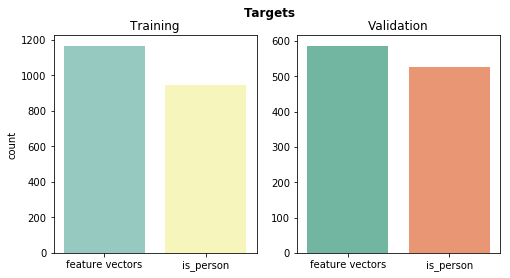

In [44]:
# Plotting training and validation targets - getting a feel of the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(By_tr, ax=ax1, palette="Set3")
ax1.set_title('Training', size=12)
ax1.set_xlabel(' ')
sns.countplot(By_val, ax=ax2, palette="Set2")
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Validation', size=12)
fig.suptitle('Targets', size=12, fontweight = 'bold')

# Using xticklabels
the_labels = ['feature vectors', 'is_person']

ax1.set_xticklabels(the_labels)
ax2.set_xticklabels(the_labels)

plt.show()

In [45]:
# Initializing a baseline
baseline_c = DummyClassifier(strategy="most_frequent")
baseline = baseline_c.fit(BX_tr, By_tr)

print('Classification accuracy for baseline DummyClassifier: {}'.format(log_loss(By_val, baseline.predict_proba(BX_val))))


Classification accuracy for baseline DummyClassifier: 16.3539399462


In [46]:
# Mean and Std. dev for training set, first 5 features
print('Mean for first 5 features in the training set:\n{}'.format(BX_tr.mean(axis=0)[0:5]))
print()
print('Std. Dev for first 5 features in the training set:\n{}'.format(BX_tr.std(axis=0)[0:5]))

Mean for first 5 features in the training set:
[ 0.04335278  0.05082978  0.04798776  0.03741056  0.04336504]

Std. Dev for first 5 features in the training set:
[ 0.51313883  0.58270116  0.48205233  0.46450079  0.49107059]


In [47]:
# Now let's start feature engineering \(O.O)/

# Instantiate StandardScaler and fit using training features
standard_scaler = StandardScaler().fit(BX_tr)

# Feature standardisation for training and validation features
BX_tr = standard_scaler.transform(BX_tr)
BX_val = standard_scaler.transform(BX_val)
BX_test = standard_scaler.transform(BX_test)

# Mean and Std. dev for transformed training set, first 5 features
print('Mean for first 5 features in the transformed training set:\n{}'.format(BX_tr.mean(axis=0)[0:5]))
print()
print('Std. Dev for first 5 features in the transformed validation set:\n{}'.format(BX_val.std(axis=0)[0:5]))

Mean for first 5 features in the transformed training set:
[ -1.34508800e-17   8.40680000e-18   2.10170000e-18  -4.20340000e-18
  -3.36272000e-18]

Std. Dev for first 5 features in the transformed validation set:
[ 0.00235501  0.00234014  0.00803716  0.00304919  0.0031713 ]


In [48]:
# Cross Validation

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(train_B)


5

In [49]:
# 1st try with SVMs

# Linear SVM
svc_linear2 = SVC(kernel = 'linear', probability=True)
svc_linear2.fit(BX_tr, By_tr)

print('Log loss with Linear SVM')
print('Training sets: {}'.format(log_loss(By_val, svc_linear2.predict(BX_val))))
print('Validation sets: {}'.format(log_loss(By_val, svc_linear2.predict(BX_val))))
print()

# Radial Basis SVM
svc_rbf2 = SVC(kernel='rbf', probability=True,)
svc_rbf2.fit(BX_tr, By_tr)

print('Log loss with Radial Basis SVM')
print('Training sets: {}'.format(log_loss(By_val, svc_rbf2.predict_proba(BX_val))))
print('Validation sets: {}'.format(log_loss(By_val, svc_rbf2.predict_proba(BX_val))))
print()

# Polynomial SVM
svc_poly2 = SVC(kernel='poly', probability=True)
svc_poly2.fit(BX_tr, By_tr)

print('Log loss with Polynomial SVM')
print('Training sets: {}'.format(log_loss(By_val, svc_poly2.predict_proba(BX_val))))
print('Validation sets: {}'.format(log_loss(By_val, svc_poly2.predict_proba(BX_val))))

#svc_rbf2.predict(BX_test)

Log loss with Linear SVM
Training sets: 16.3539399462
Validation sets: 16.3539399462

Log loss with Radial Basis SVM
Training sets: 0.69308648827
Validation sets: 0.69308648827

Log loss with Polynomial SVM
Training sets: 0.692955180862
Validation sets: 0.692955180862


In [50]:
# 2nd try with Gaussian Naive Bayes

G_nb = GaussianNB()
G_nb.fit(BX_tr, By_tr)

gnb_ll = log_loss(By_val, G_nb.predict_proba(BX_val))
print('Log loss for Gaussian Naive Bayes: {}'.format(gnb_ll))

Log loss for Gaussian Naive Bayes: 18.1848364487


In [51]:
# 3rd try with Random Forest

rf = RandomForestClassifier(n_estimators = 5000, criterion= 'entropy', random_state=42).fit(BX_tr, By_tr)

rf_ll = log_loss(By_val, rf.predict_proba(BX_val))
print('Log loss for Random Forest: {}'.format(rf_ll))

Log loss for Random Forest: 0.58247660387


In [52]:
# 4th try with Decision Tree 

DT = DecisionTreeClassifier(random_state=0).fit(BX_tr, By_tr)

DT_ll = log_loss(By_val, DT.predict_proba(BX_val))
print('Log loss for Decision Tree: {}'.format(DT_ll))

Log loss for Decision Tree: 14.3678827231


In [53]:
#5th try with Extra Trees Classifier

ET = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(BX_tr, By_tr)

ET_ll = log_loss(By_val, ET.predict_proba(BX_val))
print('Log loss for Extra Trees: {}'.format(ET_ll))

Log loss for Extra Trees: 0.753134240373


In [54]:
# 6th try with nearest neighbours 

NN = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree').fit(BX_tr, By_tr)

NN_ll = log_loss(By_val, NN.predict_proba(BX_val))
print('Log loss for Extra Trees: {}'.format(NN_ll))

Log loss for Extra Trees: 7.05148333976


In [55]:
# 7th try with my own ensemble 

from sklearn.ensemble import VotingClassifier

clf1 = SVC(kernel='poly', probability=True)
clf2 = RandomForestClassifier(n_estimators = 5000).fit(BX_tr, By_tr)

#VC = VotingClassifier(estimators=[('RBF_SVM', clf1), ('RandFor', clf2)])
#VC = VC.fit(BX_tr, By_tr)
#VC_ll = log_loss(By_val, VC.predict_proba(BX_val))
#print('Log loss for Extra Trees: {}'.format(VC_ll))
    
VC2 = VotingClassifier(estimators=[('RBF_SVM', clf1), ('RandFor', clf2)], voting='soft')
VC2 = VC2.fit(BX_tr, By_tr)
VC2_ll = log_loss(By_val, VC2.predict_proba(BX_val))
print('Log loss for Ensemble: {}'.format(VC2_ll))
   

Log loss for Ensemble: 0.627010041186


In [56]:
# Running it on the test set 

rf_ll_t = rf.predict_proba(BX_test)
print('Prediction for Random Forest: {}'.format(rf_ll_t))
rf_ll_t.shape

Prediction for Random Forest: [[ 0.8296  0.1704]
 [ 0.7956  0.2044]
 [ 0.47    0.53  ]
 ..., 
 [ 0.535   0.465 ]
 [ 0.6052  0.3948]
 [ 0.427   0.573 ]]


(1114, 2)

In [57]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(rf_ll_t) 

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)